<a href="https://colab.research.google.com/github/Sarathprasad10/Fall_Detection/blob/main/05_8_2025FallDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Slightly improved version of the 04/08/2025 Fall Detection system with bounding boxes around fallen individuals for clearer visualization.**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install ultralytics
!pip install deep_sort_realtime
!pip install ultralytics opencv-python numpy


In [ ]:
from google.colab.patches import cv2_imshow
from IPython.display import clear_output


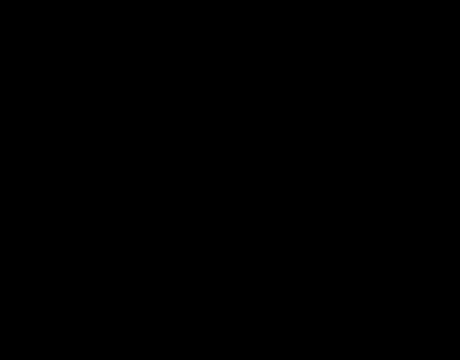

✅ FINAL fall detection with improved logic complete! Output saved to: /content/drive/MyDrive/Colab Notebooks/FallDetetction/04082025FallDetection_Improved.mp4


In [ ]:
# [Same imports as your current code]
import cv2
import numpy as np
from ultralytics import YOLO
import torch
from deep_sort_realtime.deepsort_tracker import DeepSort
from google.colab.patches import cv2_imshow
from IPython.display import clear_output
import math

# [Device, model, tracker setup]
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = YOLO("yolov8n-pose.pt").to(device)
tracker = DeepSort(max_age=30)

# [Stick pairs remain unchanged]
stick_pairs = [
    (5, 7), (7, 9), (6, 8), (8, 10),
    (11, 13), (13, 15), (12, 14), (14, 16),
    (5, 6), (11, 12), (5, 11), (6, 12)
]

# [Video paths]
video_path = "/content/drive/MyDrive/Colab Notebooks/FallDetetction/videoplayback.mp4"
output_path = "/content/drive/MyDrive/Colab Notebooks/FallDetetction/05082025FallDetection_Improved.mp4"

# [Capture settings]
cap = cv2.VideoCapture(video_path)
input_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
input_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (input_width, input_height))
preview_w, preview_h = 460, 360

# [Thresholds]
FALL_FRAMES_THRESHOLD = 5
POSE_CONFIDENCE_THRESHOLD = 0.4
MIN_PERSON_HEIGHT = input_height * 0.1

fall_counters = {}
pose_history = {}

def bbox_area(keypoints):
    x_coords = [pt[0] for pt in keypoints if pt[0] > 0]
    y_coords = [pt[1] for pt in keypoints if pt[1] > 0]
    if not x_coords or not y_coords:
        return 0
    width = max(x_coords) - min(x_coords)
    height = max(y_coords) - min(y_coords)
    return width * height

def is_kicking_pose(keypoints):
    try:
        left_leg = [keypoints[11], keypoints[13], keypoints[15]]
        right_leg = [keypoints[12], keypoints[14], keypoints[16]]

        def leg_angle(hip, knee, ankle):
            a = np.array(hip)
            b = np.array(knee)
            c = np.array(ankle)
            ab = b - a
            cb = b - c
            cosine_angle = np.dot(ab, cb) / (np.linalg.norm(ab) * np.linalg.norm(cb) + 1e-6)
            angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
            return np.degrees(angle)

        left_angle = leg_angle(*left_leg)
        right_angle = leg_angle(*right_leg)

        if ((160 <= left_angle <= 180 and 60 <= right_angle <= 120) or
            (160 <= right_angle <= 180 and 60 <= left_angle <= 120)):
            return True
        return False
    except:
        return False

def is_fall_advanced(keypoints, history):
    try:
        kp = {i: keypoints[i] for i in range(17)}
        left_shoulder, right_shoulder = kp[5], kp[6]
        left_hip, right_hip = kp[11], kp[12]
        left_knee, right_knee = kp[13], kp[14]
        left_ankle, right_ankle = kp[15], kp[16]
        nose = kp[0]

        head_y = nose[1]
        ankle_y_values = [pt[1] for pt in [left_ankle, right_ankle] if pt[1] > 0 and pt[1] < input_height]
        lowest_y = max(ankle_y_values) if ankle_y_values else max(left_hip[1], right_hip[1])
        skeleton_height = abs(lowest_y - head_y)
        if skeleton_height > 0.75 * input_height:
            return False

        required_parts = [5, 6, 11, 12, 13, 14, 15, 16]
        visible_count = sum(
            1 for i in required_parts
            if i < len(history[-1]) and not np.isnan(history[-1][i]).any()
        )
        if visible_count < 5:
            return False

        x_coords = [pt[0] for pt in keypoints if pt[0] > 0]
        y_coords = [pt[1] for pt in keypoints if pt[1] > 0]
        if not x_coords or not y_coords:
            return False
        width = max(x_coords) - min(x_coords)
        height = max(y_coords) - min(y_coords)
        aspect_ratio = width / height if height > 0 else 0

        body_area_ratio = (width * height) / (input_width * input_height)
        if body_area_ratio > 0.25:
            return False
        margin = 50
        if min(x_coords) < margin or max(x_coords) > input_width - margin:
            return False
        if width > input_width * 0.6 or height > input_height * 0.6:
            return False

        shoulder_center = np.mean([left_shoulder, right_shoulder], axis=0)
        hip_center = np.mean([left_hip, right_hip], axis=0)
        dx, dy = shoulder_center[0] - hip_center[0], shoulder_center[1] - hip_center[1]
        angle = abs(math.degrees(math.atan2(dy, dx)))
        head_hip_dist = np.linalg.norm(nose - hip_center)

        if len(history) >= 3:
            prev = np.array(history[-3])
            curr = np.array(history[-1])
            movement = np.linalg.norm(curr - prev, axis=1).mean()
        else:
            movement = 0

        if is_kicking_pose(keypoints):
            return False

        if angle > 60 and aspect_ratio < 0.6 and head_hip_dist < 50:
            return False

        return (
            (angle < 40 and aspect_ratio > 0.8) or
            (angle > 70 and aspect_ratio > 0.9) or
            (head_hip_dist < 40) or
            (movement > 20 and angle < 50 and aspect_ratio > 0.75)
        )

    except:
        return False
# ----- MAIN LOOP -----
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame, verbose=False)
    detections, kpts_list, conf_list = [], [], []

    for result in results:
        if result.boxes is None or result.keypoints is None or len(result.boxes.xyxy) == 0:
            continue

        for i, box in enumerate(result.boxes.xyxy.cpu().numpy()):
            x1, y1, x2, y2 = box
            if (y2 - y1) < MIN_PERSON_HEIGHT:
                continue

            kpts = result.keypoints.xy[i].cpu().numpy()
            confs = result.keypoints.conf[i].cpu().numpy()

            visible_kpts = sum(confs > POSE_CONFIDENCE_THRESHOLD)
            if visible_kpts < 10:
                continue

            area_ratio = bbox_area(kpts) / (input_width * input_height)
            if area_ratio > 0.4:
                continue

            detections.append(([x1, y1, x2 - x1, y2 - y1], 0.99, "person"))
            kpts_list.append(kpts)
            conf_list.append(confs)

    tracks = tracker.update_tracks(detections, frame=frame)
    active_ids = set()

    for track in tracks:
        if not track.is_confirmed():
            continue

        track_id = track.track_id
        active_ids.add(track_id)
        bbox = track.to_ltrb()
        cx = int((bbox[0] + bbox[2]) / 2)
        cy = int((bbox[1] + bbox[3]) / 2)

        best_kpts, best_confs, min_dist = None, None, 1e9
        for kpts, confs in zip(kpts_list, conf_list):
            dist = np.linalg.norm(np.mean(kpts, axis=0) - np.array([cx, cy]))
            if dist < min_dist:
                min_dist = dist
                best_kpts = kpts
                best_confs = confs

        if best_kpts is None:
            continue

        pose_history.setdefault(track_id, []).append(best_kpts)
        pose_history[track_id] = pose_history[track_id][-5:]

        is_fallen = is_fall_advanced(best_kpts, pose_history[track_id])
        fall_counters[track_id] = fall_counters.get(track_id, 0) + 1 if is_fallen else 0
        sustained_fall = fall_counters[track_id] >= FALL_FRAMES_THRESHOLD

        label = f"ID {track_id}: Fall" if sustained_fall else f"ID {track_id}: Normal"
        color = (0, 0, 255) if sustained_fall else (0, 255, 0)

        # Draw stick pose
        for a, b in stick_pairs:
            if (
                a < len(best_kpts) and b < len(best_kpts)
                and best_confs[a] > POSE_CONFIDENCE_THRESHOLD and best_confs[b] > POSE_CONFIDENCE_THRESHOLD
                and not np.isnan(best_kpts[a]).any() and not np.isnan(best_kpts[b]).any()
            ):
                pt1 = tuple(np.round(best_kpts[a]).astype(int))
                pt2 = tuple(np.round(best_kpts[b]).astype(int))
                cv2.line(frame, pt1, pt2, color, 2)

        # Optional: draw rectangle around person if fall detected
        if sustained_fall:
            cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color, 2)

        # Draw label background
        text_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
        cv2.rectangle(frame,
                      (int(bbox[0]), int(bbox[1]) - 20),
                      (int(bbox[0]) + text_size[0], int(bbox[1])),
                      color, -1)
        cv2.putText(frame, label, (int(bbox[0]), int(bbox[1]) - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    # 🧹 Cleanup stale track histories to save memory
    pose_history = {k: v for k, v in pose_history.items() if k in active_ids}
    fall_counters = {k: v for k, v in fall_counters.items() if k in active_ids}

    out.write(frame)
    preview = cv2.resize(frame, (preview_w, preview_h))
    clear_output(wait=True)
    cv2_imshow(preview)

cap.release()
out.release()
print("✅ FINAL fall detection with improved logic complete! Output saved to:", output_path)
